# Imports & file locations

In [89]:

%load_ext autoreload
%autoreload 2

import itertools

import numpy as np
import scanpy as sc
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

# Necessary for 3d plotting
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

from xspecies import CrossSpeciesComparison, SPECIES_PALETTE, PerGroupAgg


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
indir_local = '/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/'

In [3]:
outdir_gdrive = '/home/olga/googledrive/TabulaMicrocebus/data/cross-species/correlation'
outdir_local = '/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/correlation'
outdirs = outdir_local, outdir_gdrive
for d in outdirs:
    ! mkdir -p $d
!ls -lha $outdir_local

total 8.1M
drwxr-xr-x  2 olga czb 4.0K Jun  4 09:42 .
drwxrwxr-x 14 olga czb 8.0K May 26 08:39 ..
-rw-r--r--  1 olga czb 6.2M Jun  3 10:39 cross_species_median_diffs_tidy.csv
-rw-r--r--  1 olga czb 449K Jun  3 10:39 cross_species_median_diffs_tidy.parquet
-rw-r--r--  1 olga czb 1.5M Jun  4 09:42 narrow_medians_nonzero.csv


# Load data

In [4]:
%%time
h5ad = f'{indir_local}/concatenated__human-lung--lemur-lung--mouse-lung__10x__one2one_orthologs__unified_compartments__bbknn.h5ad'
adata = scanpy.read_h5ad(h5ad)
adata

CPU times: user 369 ms, sys: 675 ms, total: 1.04 s
Wall time: 6.97 s


AnnData object with n_obs × n_vars = 52815 × 11761 
    obs: 'age', 'batch', 'cell', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'channel_no_10x', 'channel_tissue', 'compartment', 'compartment_id', 'free_annotation', 'individual', 'location', 'magnetic.selection', 'method', 'mouse.id', 'nGene', 'nUMI', 'n_barcodes', 'n_counts', 'n_genes', 'orig.ident', 'original_channel', 'patient', 'percent.ribo', 'possibly_contaminated_barcode', 'preparation.site', 'region', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'subtissue', 'tissue', 'tissue_free_annotation', 'compartment_updated_from_human', 'compartment_updated_from_human__with_species', 'compartment_updated_from_lemur', 'compartment_updated_from_lemur__with_species', 'narrow_group', 'broad_group', 'compartment_group', 'log_counts', 'sqrt_counts'
    var: 'mouse_lemur__gene_name', 'mouse_lemur_to_human__homology_type', 'human_to_mouse__homology_type', 'mouse__gene_name', 'gene_ids

In [5]:
adata.obs = adata.obs.replace('nan', np.nan)

In [6]:
# adata.var.loc['XIST']

## only use narrow groups that are shared across all

In [7]:
adata_same_narrow_group = adata[adata.obs.groupby('narrow_group').filter(lambda x: x.species.nunique() == 3).index]
adata_same_narrow_group

View of AnnData object with n_obs × n_vars = 43114 × 11761 
    obs: 'age', 'batch', 'cell', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'channel_no_10x', 'channel_tissue', 'compartment', 'compartment_id', 'free_annotation', 'individual', 'location', 'magnetic.selection', 'method', 'mouse.id', 'nGene', 'nUMI', 'n_barcodes', 'n_counts', 'n_genes', 'orig.ident', 'original_channel', 'patient', 'percent.ribo', 'possibly_contaminated_barcode', 'preparation.site', 'region', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'subtissue', 'tissue', 'tissue_free_annotation', 'compartment_updated_from_human', 'compartment_updated_from_human__with_species', 'compartment_updated_from_lemur', 'compartment_updated_from_lemur__with_species', 'narrow_group', 'broad_group', 'compartment_group', 'log_counts', 'sqrt_counts'
    var: 'mouse_lemur__gene_name', 'mouse_lemur_to_human__homology_type', 'human_to_mouse__homology_type', 'mouse__gene_name', '

In [8]:
adata_same_narrow_group.obs['compartment_narrow'] = adata_same_narrow_group.obs['compartment_group'].astype(str) + ' - ' + adata_same_narrow_group.obs['narrow_group'].astype(str)
adata_same_narrow_group.obs['compartment_narrow'].value_counts().sort_index()

Trying to set attribute `.obs` of view, copying.


endothelial - Capillary                              2130
endothelial - Capillary Aerocyte                     1634
endothelial - Lymphatic                               386
endothelial - Vein                                    683
epithelial - Alveolar Epithelial Type 2              4266
epithelial - Ciliated                                1303
lymphoid - B cell                                     342
lymphoid - CD4+ T                                     444
lymphoid - CD8+ T                                     424
lymphoid - Natural Killer                             770
lymphoid - Natural Killer T cell                      109
lymphoid - Plasma                                     249
lymphoid - Proliferating NK/T                         512
myeloid - Macrophage                                18720
myeloid - Monocyte                                   5892
myeloid - Myeloid Dendritic                           650
myeloid - Plasmacytoid Dendritic                      161
myeloid - Prol

In [9]:
outdir_gdrive = '/home/olga/googledrive/TabulaMicrocebus/data/cross-species/correlation'
outdir_local = '/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/correlation'
outdirs = outdir_local, outdir_gdrive
# for d in outdirs:
#     ! mkdir -p $d
!ls -lha $outdir_local

total 8.1M
drwxr-xr-x  2 olga czb 4.0K Jun  4 09:42 .
drwxrwxr-x 14 olga czb 8.0K May 26 08:39 ..
-rw-r--r--  1 olga czb 6.2M Jun  3 10:39 cross_species_median_diffs_tidy.csv
-rw-r--r--  1 olga czb 449K Jun  3 10:39 cross_species_median_diffs_tidy.parquet
-rw-r--r--  1 olga czb 1.5M Jun  4 09:42 narrow_medians_nonzero.csv


## Read medians

In [10]:
csv = f'{outdir_local}/narrow_medians_nonzero.csv'
medians = pd.read_csv(csv, index_col=0, header=[0, 1])
print(medians.shape)
medians.head()

(5449, 66)


human                                   \
         endothelial - Capillary endothelial - Capillary Aerocyte   
ISG15                        1.0                              1.0   
AGRN                         0.0                              0.0   
TTLL10                       0.0                              0.0   
TNFRSF18                     0.0                              0.0   
TNFRSF4                      0.0                              0.0   

                                                     \
         endothelial - Lymphatic endothelial - Vein   
ISG15                        0.0                1.0   
AGRN                         0.0                0.0   
TTLL10                       0.0                0.0   
TNFRSF18                     0.0                0.0   
TNFRSF4                      0.0                0.0   

                                                                        \
         epithelial - Alveolar Epithelial Type 2 epithelial - Ciliated   
ISG15                                        0.0                   0.0   
AGRN                                         0.0                   0.0   
TTLL10                                       0.0                   1.0   
TNFRSF18                                     0.0                   0.0   
TNFRSF4                                      0.0                   0.0   

                                                                \
         lymphoid - B cell lymphoid - CD4+ T lymphoid - CD8+ T   
ISG15                  0.0               1.0               1.0   
AGRN                   0.0               0.0               0.0   
TTLL10                 0.0               0.0               0.0   
TNFRSF18               0.0               0.0               0.0   
TNFRSF4                0.0               0.0               0.0   

                                                                     \
         lymphoid - Natural Killer lymphoid - Natural Killer T cell   
ISG15                          0.0                              0.0   
AGRN                           0.0                              0.0   
TTLL10                         0.0                              0.0   
TNFRSF18                       0.0                              0.0   
TNFRSF4                        0.0                              0.0   

                                                                               \
         lymphoid - Plasma lymphoid - Proliferating NK/T myeloid - Macrophage   
ISG15                  0.0                           1.0                  4.0   
AGRN                   0.0                           0.0                  0.0   
TTLL10                 0.0                           0.0                  0.0   
TNFRSF18               1.0                           0.0                  0.0   
TNFRSF4                1.0                           0.0                  0.0   

                                                         \
         myeloid - Monocyte myeloid - Myeloid Dendritic   
ISG15                   1.0                         0.5   
AGRN                    0.0                         0.0   
TTLL10                  0.0                         0.0   
TNFRSF18                0.0                         0.0   
TNFRSF4                 0.0                         0.0   

                                                                              \
         myeloid - Plasmacytoid Dendritic myeloid - Proliferating Macrophage   
ISG15                                 0.0                                4.0   
AGRN                                  0.0                                0.0   
TTLL10                                0.0                                0.0   
TNFRSF18                              0.0                                0.0   
TNFRSF4                               0.0                                0.0   

                                           \
         stromal - Adventitial Fibroblast   
ISG15                                 0.0   

In [11]:
ls -lha $csv

-rw-r--r-- 1 olga czb 1.5M Jun  4 09:42 /home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/correlation/narrow_medians_nonzero.csv


In [12]:
medians_tidy = medians.stack(level=1)
print(medians_tidy.shape)
# Add 1 and do log10
medians_tidy = np.log10(medians_tidy + 1)
medians_tidy = medians_tidy.reset_index()
medians_tidy = medians_tidy.rename(columns={'level_0': 'gene_name', 
                                            'level_1': 'compartment_narrow'})
medians_tidy.head()

(119878, 3)


,gene_name,compartment_narrow,human,lemur,mouse
0,ISG15,endothelial - Capillary,0.30103,0.0,0.0
1,ISG15,endothelial - Capillary Aerocyte,0.30103,0.0,0.0
2,ISG15,endothelial - Lymphatic,0.00000,0.0,0.0
3,ISG15,endothelial - Vein,0.30103,0.0,0.0
4,ISG15,epithelial - Alveolar Epithelial Type 2,0.00000,0.0,0.0


# Matplotlib 3d

In [13]:
pwd

'/home/olga/code/tabula-microcebus--olgabot/xspecies-lung-de-within-species/notebooks'

## Make AT2 adata

In [20]:
adata_at2 = adata[adata.obs.query('narrow_group == "Alveolar Epithelial Type 2"').index]
adata_at2

View of AnnData object with n_obs × n_vars = 4266 × 11761 
    obs: 'age', 'batch', 'cell', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'channel_no_10x', 'channel_tissue', 'compartment', 'compartment_id', 'free_annotation', 'individual', 'location', 'magnetic.selection', 'method', 'mouse.id', 'nGene', 'nUMI', 'n_barcodes', 'n_counts', 'n_genes', 'orig.ident', 'original_channel', 'patient', 'percent.ribo', 'possibly_contaminated_barcode', 'preparation.site', 'region', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'subtissue', 'tissue', 'tissue_free_annotation', 'compartment_updated_from_human', 'compartment_updated_from_human__with_species', 'compartment_updated_from_lemur', 'compartment_updated_from_lemur__with_species', 'narrow_group', 'broad_group', 'compartment_group', 'log_counts', 'sqrt_counts'
    var: 'mouse_lemur__gene_name', 'mouse_lemur_to_human__homology_type', 'human_to_mouse__homology_type', 'mouse__gene_name', 'g

## Do differential expression


In [21]:
sc.tl.rank_genes_groups(adata_at2, 'species_batch')

ranking genes


/home/olga/miniconda3/envs/tabula-microcebus-v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1068: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning,


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/olga/miniconda3/envs/tabula-microcebus-v2/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:237: RuntimeWarning: overflow encountered in expm1
  foldchanges = (expm1_func(mean_group) + 1e-9) / (expm1_func(mean_rest) + 1e-9)  # add small value to remove 0's
/home/olga/miniconda3/envs/tabula-microcebus-v2/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:237: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (expm1_func(mean_group) + 1e-9) / (expm1_func(mean_rest) + 1e-9)  # add small value to remove 0's


In [35]:
species_to_color = dict(zip(['mouse', 'lemur', 'human'], SPECIES_PALETTE))
species_to_color

{'mouse': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'lemur': (1.0, 0.4980392156862745, 0.054901960784313725),
 'human': (0.15294117647058825, 0.6196078431372549, 0.40784313725490196)}

### Get logfoldchanges

In [29]:
logfoldchanges = CrossSpeciesComparison.extract_de_logfoldchanges(adata_at2)
print(logfoldchanges.shape)
logfoldchanges.tail()

(100, 3)


,human,lemur,mouse
95,3.716098,2.971380,4.714400
96,3.944558,3.470702,10.085399
97,8.639745,4.905193,3.883653
98,6.553810,3.226079,3.264294
99,4.858366,3.073257,4.265055


### Get P values

In [43]:
pvals = CrossSpeciesComparison.extract_de_pvals_adj(adata_at2)
print(pvals.shape)
pvals.tail()

(100, 3)


,human,lemur,mouse
95,0.000000e+00,9.170167e-73,2.663684e-12
96,0.000000e+00,3.001696e-71,8.817320e-12
97,0.000000e+00,8.523708e-70,2.639144e-12
98,3.854700e-320,2.533603e-70,2.663684e-12
99,0.000000e+00,1.782882e-70,4.642371e-12


In [111]:
pvals.describe()

,human,lemur,mouse
count,1.000000e+02,1.000000e+02,1.000000e+02
mean,3.853712e-322,1.550372e-71,4.292882e-13
std,0.000000e+00,9.087806e-71,1.257319e-12
min,0.000000e+00,1.282380e-205,3.039240e-29
25%,0.000000e+00,2.924785e-120,1.704199e-19
50%,0.000000e+00,5.368271e-93,3.869003e-16
75%,0.000000e+00,1.914304e-81,8.090153e-14
max,3.854700e-320,8.523708e-70,8.817320e-12


### Get gene names

In [28]:
gene_names = CrossSpeciesComparison.extract_de_names(adata_at2)
print(gene_names.shape)
gene_names.head()

(100, 3)


,human,lemur,mouse
0,AK1,RNF103,CD36
1,HOPX,MAMDC4,SLC34A2
2,PRDX5,VAMP5,ALCAM
3,MALL,LPCAT1,H2AFJ
4,HNRNPA1,H3F3A,BSG


## Compute mean gene expression per group

Spearman correlation of sizes vs nonzero: 0.948


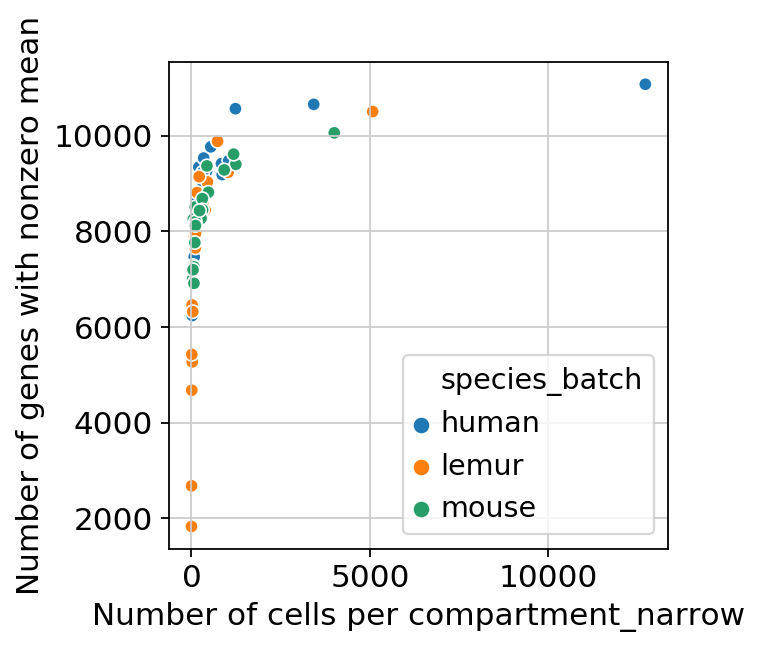

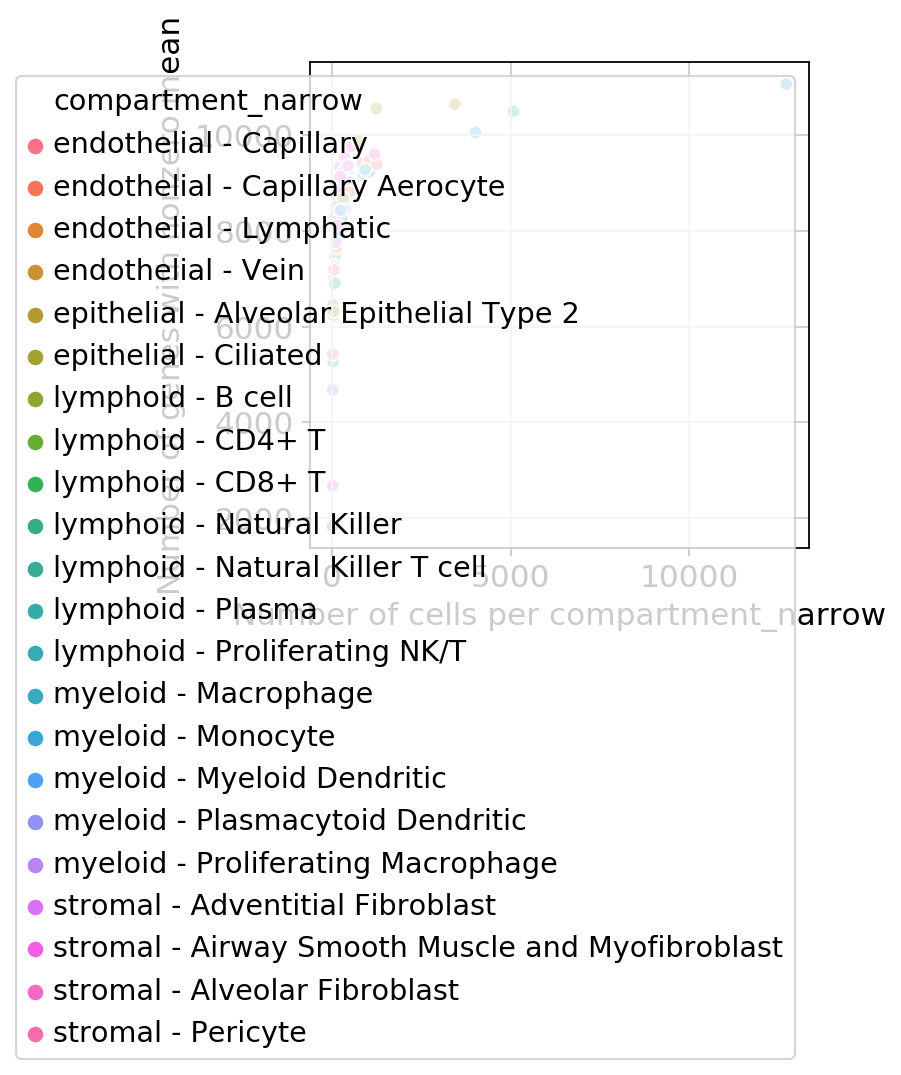

In [90]:
narrow_agg = PerGroupAgg(adata_same_narrow_group, 'compartment_narrow')
narrow_agg.do_aggregation(aggfunc='mean', plot=True)

In [94]:
narrow_means = narrow_agg.aggregated['mean']
print(narrow_means.shape)
narrow_means.head()

(11761, 66)


human                                   \
       endothelial - Capillary endothelial - Capillary Aerocyte   
SAMD11                0.001188                         0.000955   
NOC2L                 0.089074                         0.106017   
KLHL17                0.008314                         0.006686   
ISG15                 1.625891                         1.265521   
AGRN                  0.068884                         0.054441   

                                                   \
       endothelial - Lymphatic endothelial - Vein   
SAMD11                0.006993           0.081776   
NOC2L                 0.188811           0.137850   
KLHL17                0.013986           0.002336   
ISG15                 0.741259           1.289720   
AGRN                  0.073427           0.268692   

                                                                      \
       epithelial - Alveolar Epithelial Type 2 epithelial - Ciliated   
SAMD11                                0.002043              0.003244   
NOC2L                                 0.207178              0.308191   
KLHL17                                0.010797              0.016221   
ISG15                                 0.171870              1.484996   
AGRN                                  0.166326              0.515004   

                                                              \
       lymphoid - B cell lymphoid - CD4+ T lymphoid - CD8+ T   
SAMD11          0.000000          0.003012          0.000000   
NOC2L           0.083333          0.150602          0.155963   
KLHL17          0.041667          0.015060          0.000000   
ISG15           0.666667          0.942771          1.000000   
AGRN            0.000000          0.009036          0.018349   

                                                                   \
       lymphoid - Natural Killer lymphoid - Natural Killer T cell   
SAMD11                  0.000000                           0.0000   
NOC2L                   0.137931                           0.3125   
KLHL17                  0.017241                           0.0625   
ISG15                   0.663793                           0.7500   
AGRN                    0.008621                           0.0000   

                                                                             \
       lymphoid - Plasma lymphoid - Proliferating NK/T myeloid - Macrophage   
SAMD11          0.024194                      0.012048             0.002044   
NOC2L           0.169355                      0.192771             0.388727   
KLHL17          0.008065                      0.000000             0.016430   
ISG15           0.580645                      1.096386             6.129392   
AGRN            0.040323                      0.000000             0.162330   

                                                       \
       myeloid - Monocyte myeloid - Myeloid Dendritic   
SAMD11           0.001160                    0.000000   
NOC2L            0.178654                    0.274510   
KLHL17           0.010441                    0.009804   
ISG15            1.815545                    1.980392   
AGRN             0.005800                    0.045752   

                                                                            \
       myeloid - Plasmacytoid Dendritic myeloid - Proliferating Macrophage   
SAMD11                         0.000000                           0.000000   
NOC2L                          0.179487                           0.391304   
KLHL17                         0.000000                           0.009662   
ISG15                          0.410256                           5.169082   
AGRN                           0.051282                           0.251208   

                                         \
       stromal - Adventitial Fibroblast   
SAMD11                         0.261628   
NOC2L                          0.168605   
KLHL17                         0.002907   
ISG15                        

In [50]:
'SFTPC' in gene_names

False

## Get AT2 medians only

In [40]:
compartment_narrow = 'epithelial - Alveolar Epithelial Type 2'
def sanitize_compartment_narrow(x):
    return x.lower().replace(' - ', '--').replace(' ', '_')

compartment_narrow_sanitized = sanitize_compartment_narrow(compartment_narrow)
compartment_narrow_sanitized

'epithelial--alveolar_epithelial_type_2'

In [14]:
at2 = medians_tidy.query("compartment_narrow == @compartment_narrow")
print(at2.shape)
at2.head()

(5449, 5)


,gene_name,compartment_narrow,human,lemur,mouse
4,ISG15,epithelial - Alveolar Epithelial Type 2,0.0,0.0,0.0
26,AGRN,epithelial - Alveolar Epithelial Type 2,0.0,0.0,0.0
48,TTLL10,epithelial - Alveolar Epithelial Type 2,0.0,0.0,0.0
70,TNFRSF18,epithelial - Alveolar Epithelial Type 2,0.0,0.0,0.0
92,TNFRSF4,epithelial - Alveolar Epithelial Type 2,0.0,0.0,0.0


In [30]:
at2_index = at2.set_index(['gene_name'])
at2_index = at2_index.drop('compartment_narrow', axis=1)
at2_index.head()

,human,lemur,mouse
gene_name,,,
ISG15,0.0,0.0,0.0
AGRN,0.0,0.0,0.0
TTLL10,0.0,0.0,0.0
TNFRSF18,0.0,0.0,0.0
TNFRSF4,0.0,0.0,0.0


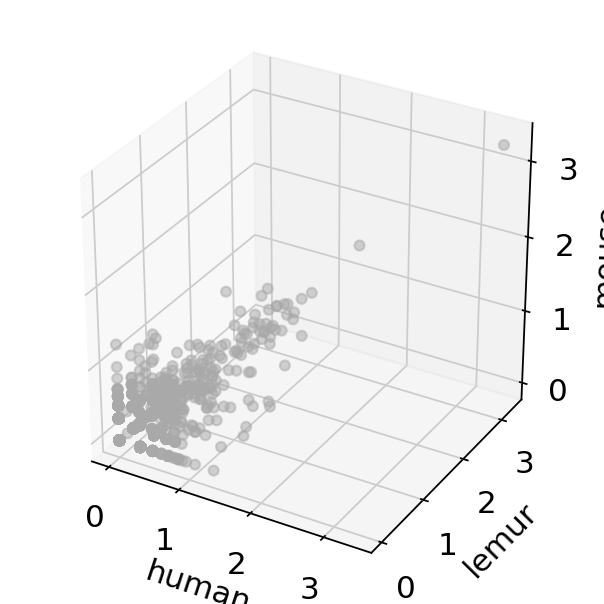

In [49]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Data for three-dimensional scattered points

ax.scatter3D(at2['human'], at2['lemur'], at2['mouse'], color='darkgrey', alpha=0.5);
ax.set(xlabel='human', ylabel='lemur', zlabel='mouse')

fig.tight_layout()
fig.savefig(f'{outdir_gdrive}/{compartment_narrow_sanitized}__3d.png')

/home/olga/miniconda3/envs/tabula-microcebus-v2/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


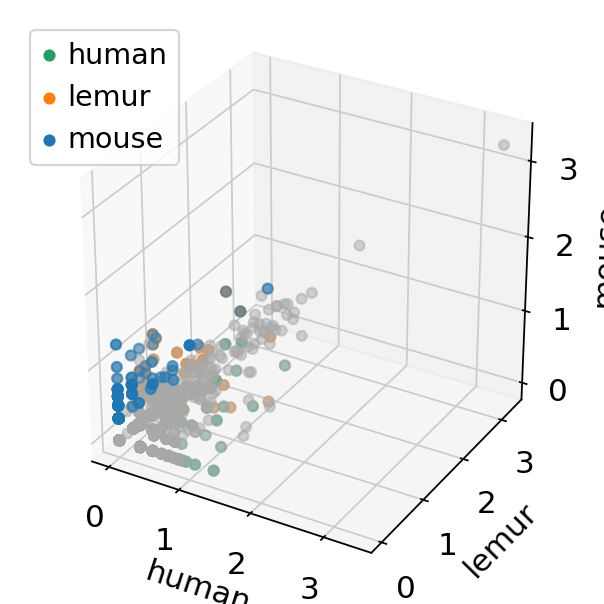

In [51]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Data for three-dimensional scattered points

ax.scatter3D(at2['human'], at2['lemur'], at2['mouse'], color='darkgrey', alpha=0.5);
ax.set(xlabel='human', ylabel='lemur', zlabel='mouse')

for species, col in gene_names.iteritems():
    subset = at2_index.loc[col.values]
    color = species_to_color[species]
    ax.scatter3D(subset['human'], subset['lemur'], subset['mouse'], color=color, 
                 label=species, zorder=100);

ax.legend()
fig.tight_layout()
fig.savefig(f'{outdir_gdrive}/{compartment_narrow_sanitized}__3d__colored.png')

## Seaborn pairgrid

In [59]:
at2_index['in_de_gene_names'] = at2_index.index.isin(gene_names.values.flatten())
at2_index.in_de_gene_names.value_counts()

In [65]:
at2_index['de_species'] = 'not_de'

for species, col in gene_names.iteritems():
    index = at2_index.index.intersection(col.values)
    at2_index.loc[index, 'de_species'] = species
at2_index['de_species'].value_counts()

not_de    5158
human      100
mouse      100
lemur       91
Name: de_species, dtype: int64

In [70]:
species_to_color = dict(zip(['mouse', 'lemur', 'human'], SPECIES_PALETTE))
species_to_color

{'mouse': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'lemur': (1.0, 0.4980392156862745, 0.054901960784313725),
 'human': (0.15294117647058825, 0.6196078431372549, 0.40784313725490196)}

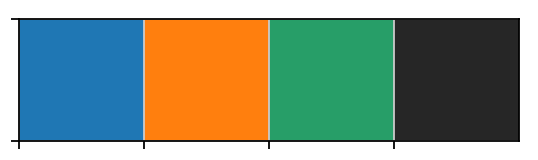

In [72]:
palette = pd.Series({k: rgb2hex(v) for k, v in species_to_color.items()})
palette['not_de'] = '#262626'
sns.palplot(palette)

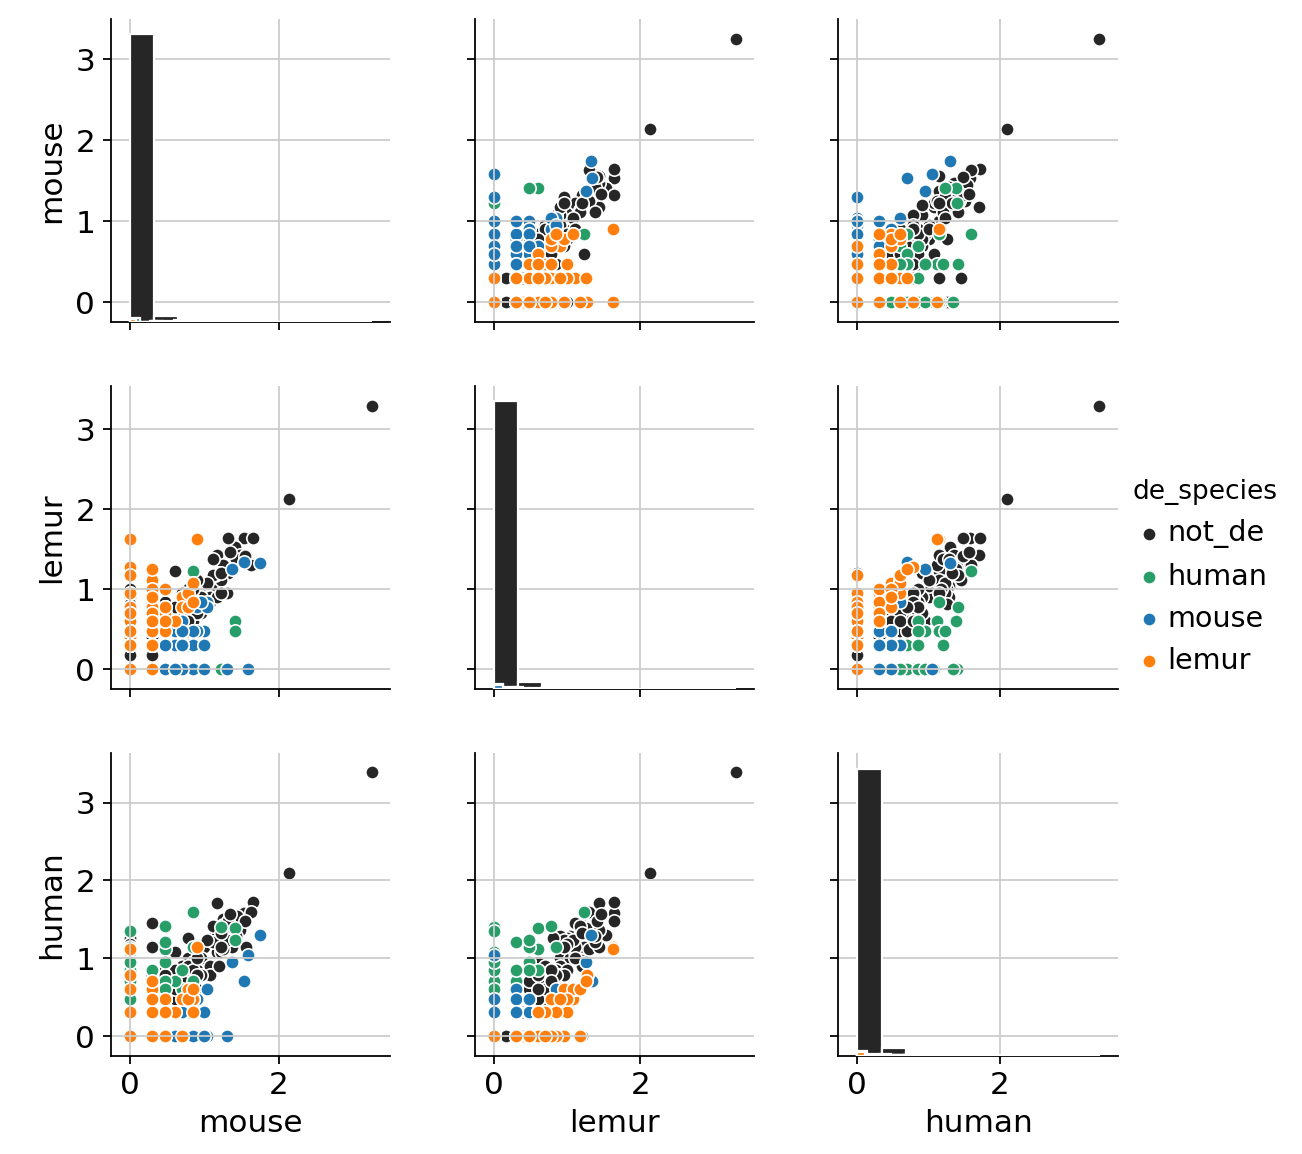

In [78]:
cols = ['mouse', 'lemur', 'human', 'de_species']

g = sns.PairGrid(at2_index[cols], hue='de_species', 
                 palette=palette.to_dict())
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.scatterplot)
g = g.map_diag(plt.hist, edgecolor='w')
g = g.add_legend()


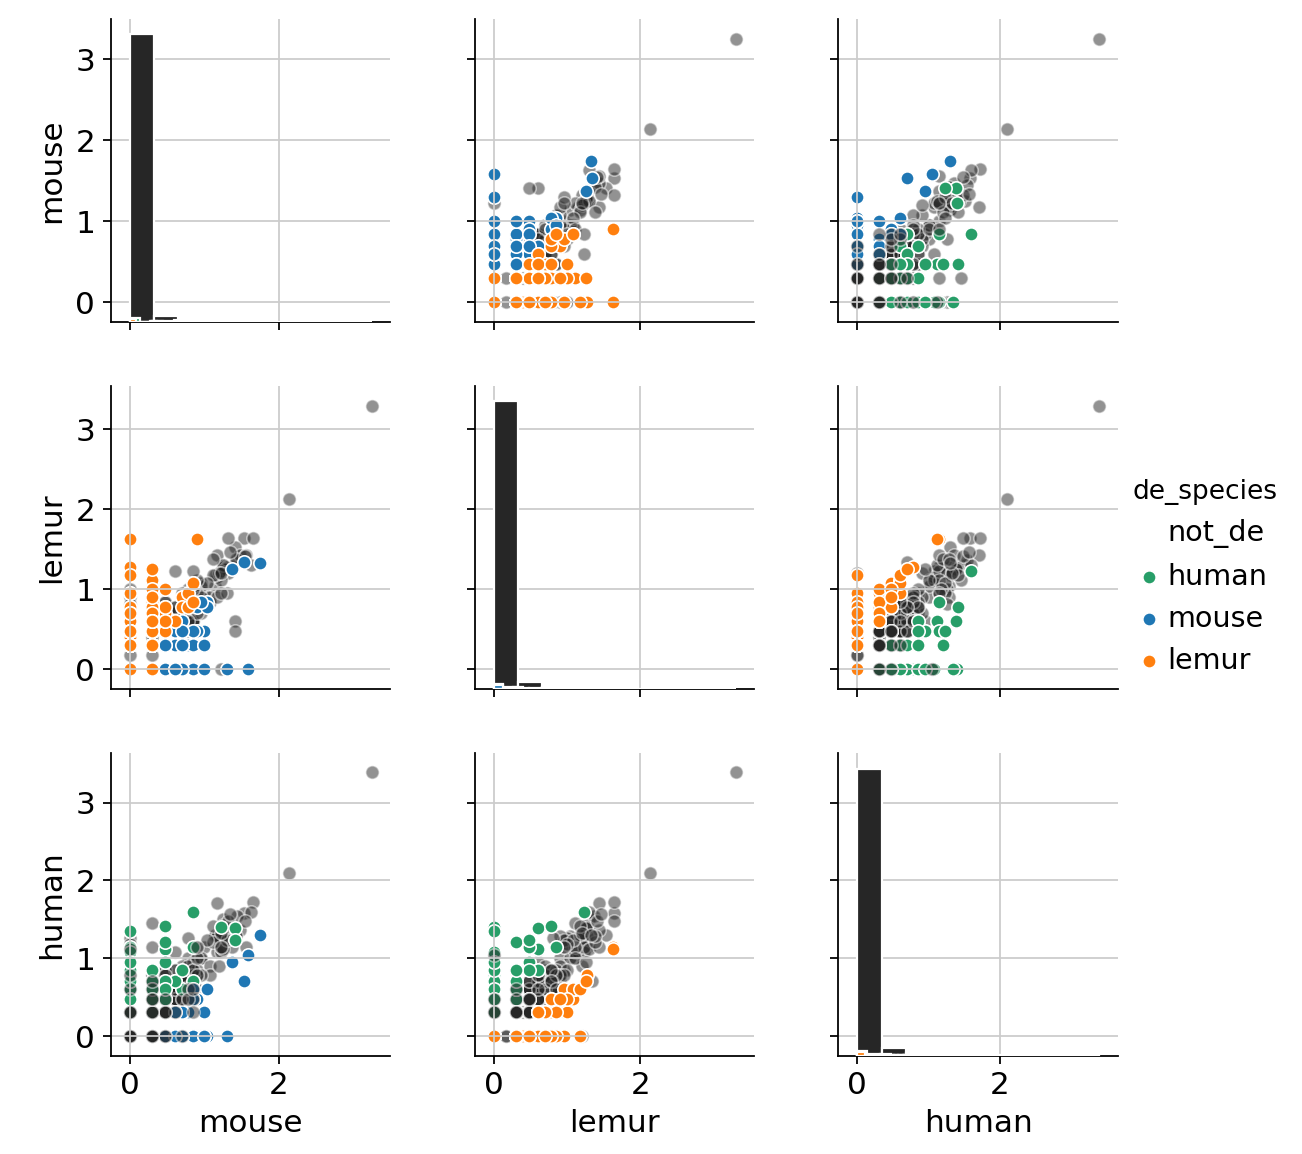

In [87]:
NON_DE_COLOR = '#262626'

def de_scatterplot(x, y, label, color, *args, **kwargs):
#     print(f'args: {args}')
#     print(f'kwargs: {kwargs}')
    
    if 'ax' not in kwargs:
        ax = plt.gca()
    else:
        ax = kwargs['ax']
        
    species_is_present = label == x.name or label == y.name
        
    if label == 'not_de' or not species_is_present:
        sns.scatterplot(x, y, label='not_de_in_pair', color=NON_DE_COLOR, 
                   alpha=0.5, **kwargs)
    else:
        sns.scatterplot(x, y, label=label, color=color, 
                   **kwargs)
    
    
    

g = sns.PairGrid(at2_index[cols], hue='de_species', 
                 palette=palette.to_dict())
g = g.map_upper(de_scatterplot)
g = g.map_lower(de_scatterplot)
g = g.map_diag(plt.hist, edgecolor='w')
g = g.add_legend()


## Same thing but with means

In [98]:
narrow_means_tidy = narrow_means.stack(level=1)
narrow_means_tidy = narrow_means_tidy.reset_index()
narrow_means_tidy = narrow_means_tidy.rename(
    columns={'level_0': 'gene_name', 'level_1': 'compartment_narrow'})
narrow_means_tidy.head()

,gene_name,compartment_narrow,human,lemur,mouse
0,SAMD11,endothelial - Capillary,0.001188,0.0,0.000000
1,SAMD11,endothelial - Capillary Aerocyte,0.000955,0.0,0.000000
2,SAMD11,endothelial - Lymphatic,0.006993,0.0,0.000000
3,SAMD11,endothelial - Vein,0.081776,0.0,0.000000
4,SAMD11,epithelial - Alveolar Epithelial Type 2,0.002043,0.0,0.009346


In [102]:
at2_means = narrow_means_tidy.query('compartment_narrow == @compartment_narrow')
at2_means = at2_means.set_index('gene_name')
at2_means = at2_means.drop('compartment_narrow', axis=1)
at2_means = np.log10(at2_means+1)
at2_means.head()

,human,lemur,mouse
gene_name,,,
SAMD11,0.000886,0.000000,0.004040
NOC2L,0.081771,0.077497,0.049797
KLHL17,0.004664,0.012284,0.008043
ISG15,0.068880,0.119566,0.012009
AGRN,0.066820,0.089731,0.046163


In [103]:
at2_means

,human,lemur,mouse
gene_name,,,
SAMD11,0.000886,0.000000,0.004040
NOC2L,0.081771,0.077497,0.049797
KLHL17,0.004664,0.012284,0.008043
ISG15,0.068880,0.119566,0.012009
AGRN,0.066820,0.089731,0.046163
...,...,...,...
MTCP1,0.001644,0.005307,0.035074
VBP1,0.170864,0.175696,0.128979
RAB39B,0.000380,0.000000,0.008043


### 3d plot

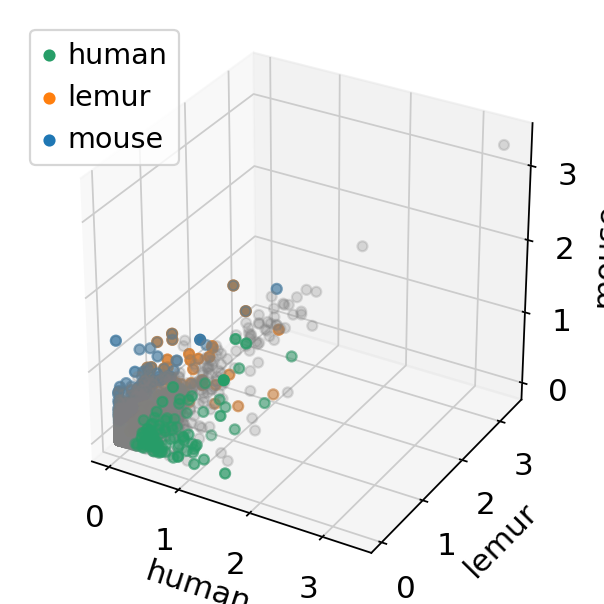

In [106]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Data for three-dimensional scattered points

ax.scatter3D(at2_means['human'], at2_means['lemur'], at2_means['mouse'], 
             color='grey', alpha=0.25);
ax.set(xlabel='human', ylabel='lemur', zlabel='mouse')

for species, col in gene_names.iteritems():
    subset = at2_means.loc[col.values]
    color = species_to_color[species]
    ax.scatter3D(subset['human'], subset['lemur'], subset['mouse'], color=color, 
                 label=species, zorder=100);

ax.legend()
fig.tight_layout()
fig.savefig(f'{outdir_gdrive}/{compartment_narrow_sanitized}__3d__colored__means.png')

### Pairgrid

In [107]:
at2_means['de_species'] = 'not_de'

for species, col in gene_names.iteritems():
    index = at2_means.index.intersection(col.values)
    at2_means.loc[index, 'de_species'] = species
at2_means['de_species'].value_counts()

not_de    11469
human       100
mouse       100
lemur        92
Name: de_species, dtype: int64

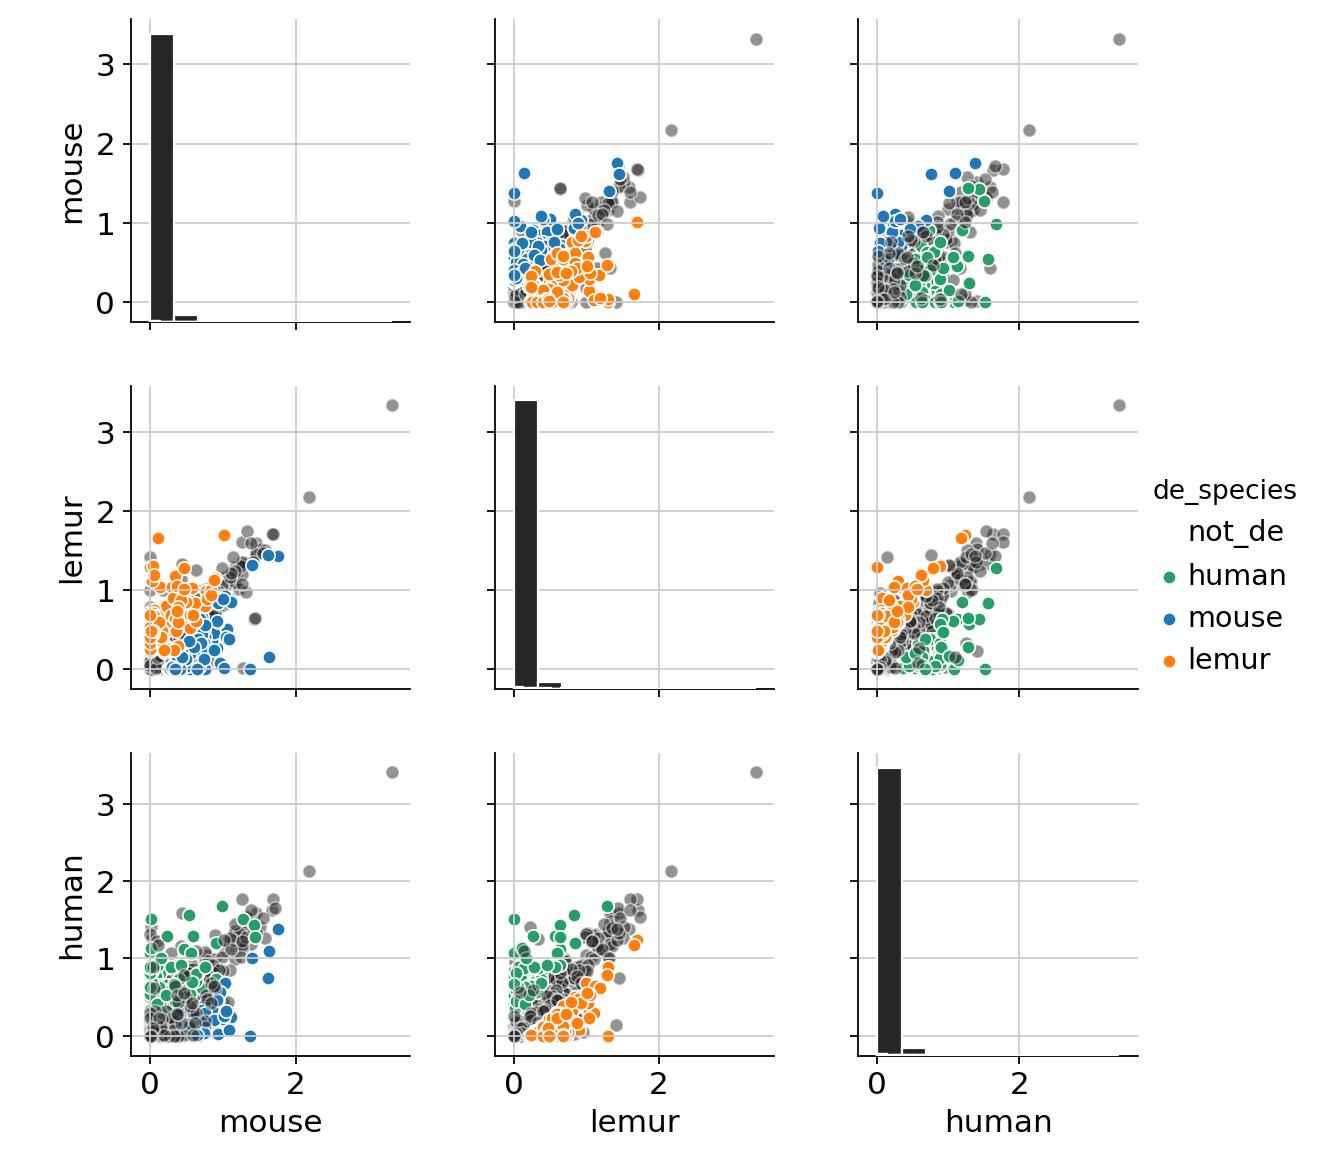

In [108]:
NON_DE_COLOR = '#262626'

def de_scatterplot(x, y, label, color, *args, **kwargs):
#     print(f'args: {args}')
#     print(f'kwargs: {kwargs}')
    
    if 'ax' not in kwargs:
        ax = plt.gca()
    else:
        ax = kwargs['ax']
        
    species_is_present = label == x.name or label == y.name
        
    if label == 'not_de' or not species_is_present:
        sns.scatterplot(x, y, label='not_de_in_pair', color=NON_DE_COLOR, 
                   alpha=0.5, **kwargs)
    else:
        sns.scatterplot(x, y, label=label, color=color, 
                   **kwargs)
    
    
    

g = sns.PairGrid(at2_means[cols], hue='de_species', 
                 palette=palette.to_dict())
g = g.map_upper(de_scatterplot)
g = g.map_lower(de_scatterplot)
g = g.map_diag(plt.hist, edgecolor='w')
g = g.add_legend()


### Pairgrid - filter by logfoldchange

In [110]:
gene_names.head()

,human,lemur,mouse
0,AK1,RNF103,CD36
1,HOPX,MAMDC4,SLC34A2
2,PRDX5,VAMP5,ALCAM
3,MALL,LPCAT1,H2AFJ
4,HNRNPA1,H3F3A,BSG


In [112]:
logfoldchanges.head()

,human,lemur,mouse
0,13.945255,9.747610,13.922594
1,20.148359,12.773713,47.011185
2,13.352663,12.101072,9.791326
3,10.693958,16.894402,15.061032
4,11.239022,10.054239,7.963280


In [114]:
logfoldchanges.describe()

,human,lemur,mouse
count,100.000000,100.000000,100.000000
mean,9.413442,9.135486,8.908016
std,9.641038,7.739737,8.611081
min,2.836372,2.971380,3.264294
25%,4.505354,4.911686,4.711923
50%,5.454755,6.974336,6.356292
75%,9.704473,10.037369,9.144860
max,53.421906,47.249352,47.011185


In [134]:
gene_names_logfoldchanges = gene_names[logfoldchanges > 10]
gene_names_logfoldchanges.describe()

,human,lemur,mouse
count,25,26,21
unique,25,26,21
top,ZFP36,LPCAT1,SLC34A2
freq,1,1,1


In [135]:
def label_genes(df, de_col, genes):

    df[de_col] = 'not_de'

    for species, col in genes.iteritems():
        index = df.index.intersection(col.dropna().values)
        df.loc[index, de_col] = species
    print(df[de_col].value_counts())
    return df
    
DE_COL = 'de_species_logfoldchanges'
at2_means = label_genes(at2_means, DE_COL, gene_names_logfoldchanges)

not_de    11692
human        25
lemur        23
mouse        21
Name: de_species_logfoldchanges, dtype: int64


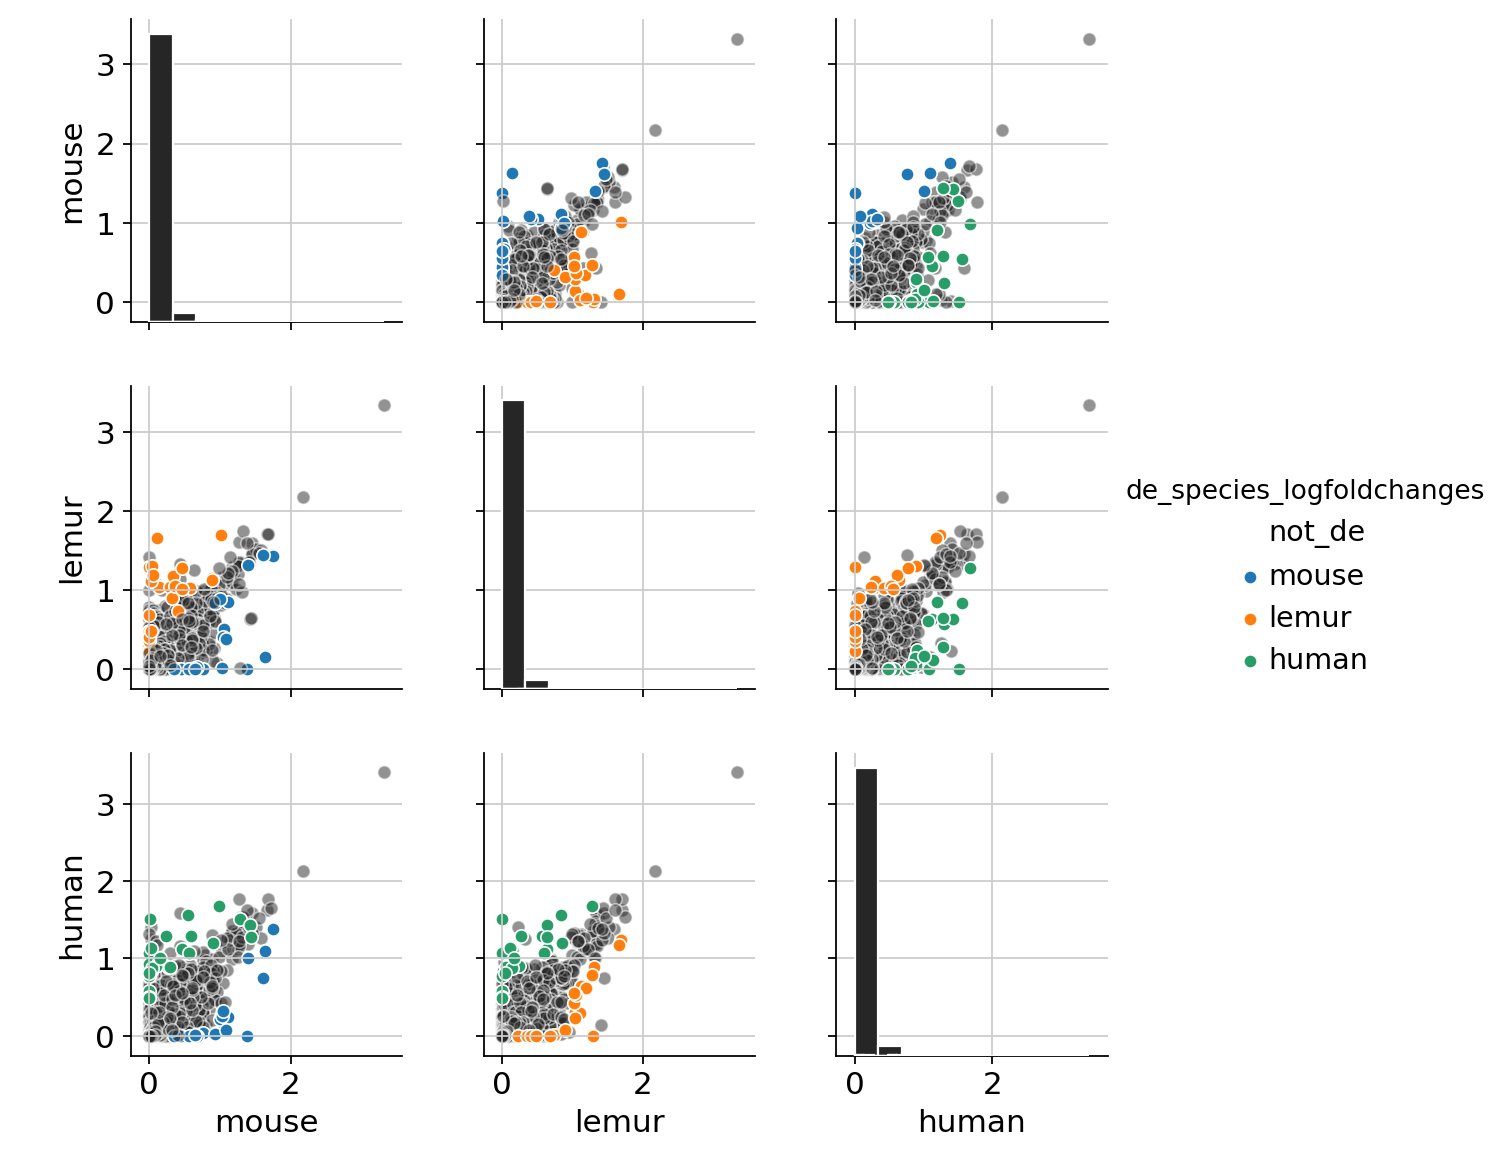

In [139]:
NON_DE_COLOR = '#262626'

def de_scatterplot(x, y, label, color, *args, **kwargs):
#     print(f'args: {args}')
#     print(f'kwargs: {kwargs}')
    
    if 'ax' not in kwargs:
        ax = plt.gca()
    else:
        ax = kwargs['ax']
        
    species_is_present = label == x.name or label == y.name
        
    if label == 'not_de' or not species_is_present:
        sns.scatterplot(x, y, label='not_de_in_pair', color=NON_DE_COLOR, 
                   alpha=0.5, **kwargs)
    else:
        sns.scatterplot(x, y, label=label, color=color, 
                   **kwargs)

cols = ['mouse', 'lemur', 'human', DE_COL]

g = sns.PairGrid(at2_means[cols], hue=DE_COL, 
                 palette=palette.to_dict())
g = g.map_upper(de_scatterplot)
g = g.map_lower(de_scatterplot)
g = g.map_diag(plt.hist, edgecolor='w')
g = g.add_legend()
g.savefig(f'{outdir_gdrive}/{compartment_narrow_sanitized}__pairgrid__colored__means.png')

### 3d plot - filter by llogfoldchange

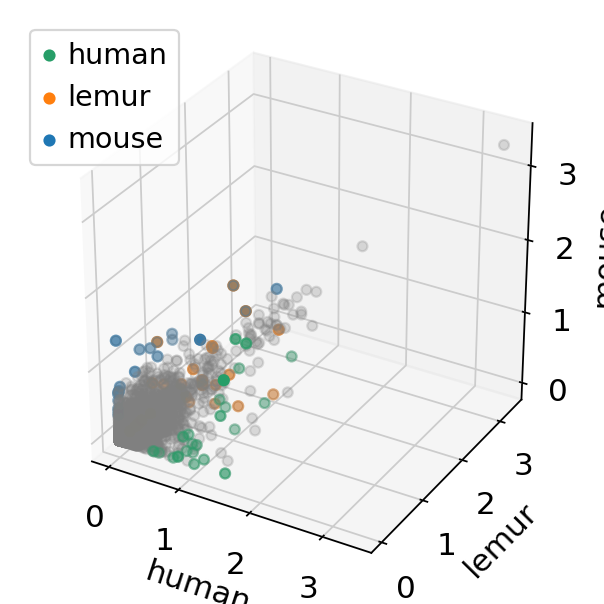

In [138]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Data for three-dimensional scattered points

ax.scatter3D(at2_means['human'], at2_means['lemur'], at2_means['mouse'], 
             color='grey', alpha=0.25);
ax.set(xlabel='human', ylabel='lemur', zlabel='mouse')

for species, col in gene_names_logfoldchanges.iteritems():
    subset = at2_means.loc[col.dropna().values]
    color = species_to_color[species]
    ax.scatter3D(subset['human'], subset['lemur'], subset['mouse'], color=color, 
                 label=species, zorder=100);

ax.legend()
fig.tight_layout()
fig.savefig(f'{outdir_gdrive}/{compartment_narrow_sanitized}__3d__colored__means.png')